**Anomaly detection**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

In [2]:
dataframe = pd.read_csv('/content/raw.githubusercontent.com_kanesp_ECG_Anomaly-Detection_main_data_ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

Load ECG data

In [42]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)
data.shape

(4998, 140)

**Normalize the data**

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

**Plot a normal ECG.**

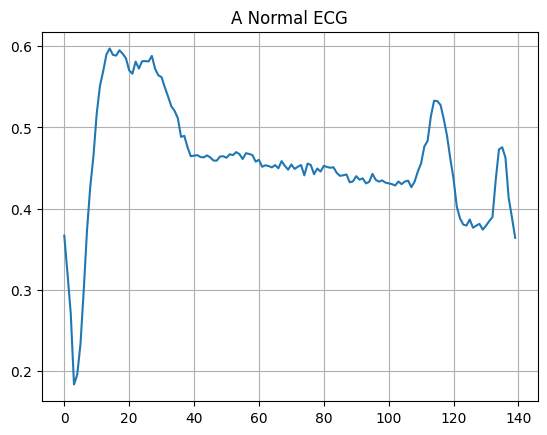

In [10]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[14])
plt.title("A Normal ECG")
plt.show()

**Plot an anomalous ECG.**

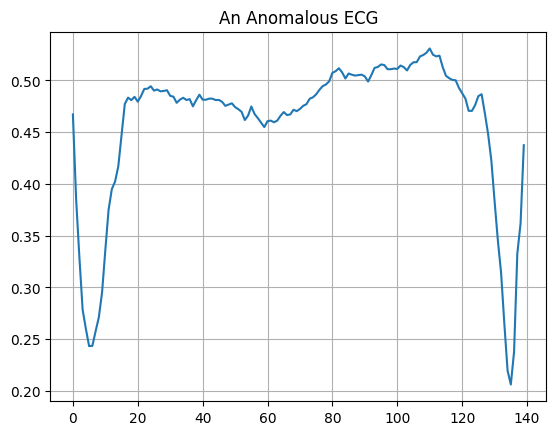

In [11]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[3])
plt.title("An Anomalous ECG")
plt.show()

**Build the model**

In [12]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam', loss='mae')

In [14]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 57ms/step - loss: 0.0588 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0563 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0542 - val_loss: 0.0501
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0509 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0476 - val_loss: 0.0468
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0402 - val_loss: 0.0425
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0367 - val_loss: 0.0409
Epoch 9/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0337 - val_loss: 0.0396
Epoch 10/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0315 - val_loss: 0.0390
Epoch 11/20
5/5 [============

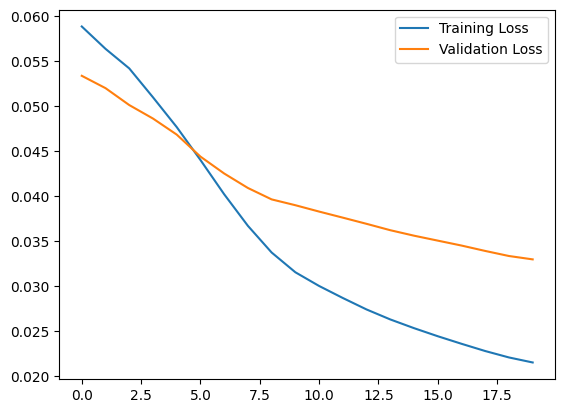

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

we will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

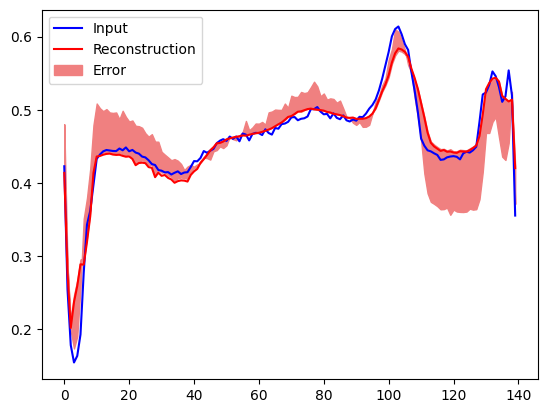

In [18]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[100], 'b')
plt.plot(decoded_data[100], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

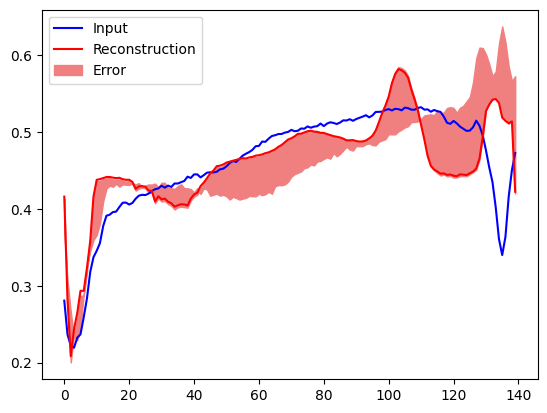

In [23]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[10], 'b')
plt.plot(decoded_data[10], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Detect anomalies**


Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 2ms/step


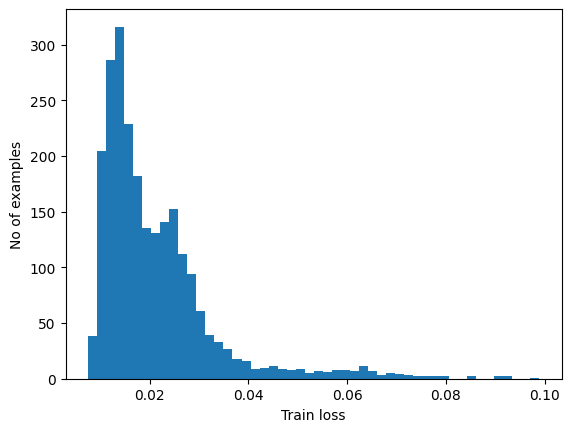

In [24]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [25]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03318587


If we examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

14/14 [==============================] - 0s 2ms/step


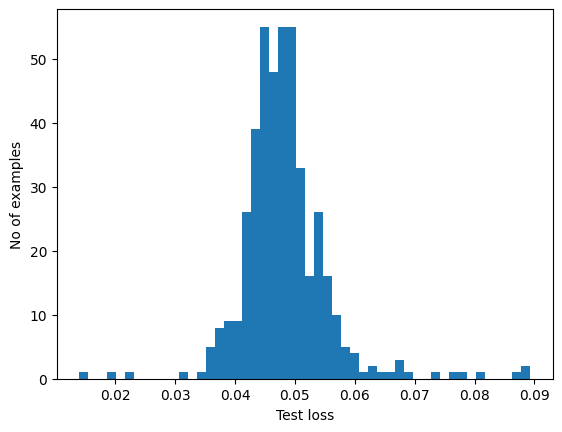

In [26]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [27]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [28]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


In [ ]:
single_ecg = ...  # Replace with your ECG signal
preprocessed_single_ecg = (single_ecg - min_val) / (max_val - min_val)
preprocessed_single_ecg = tf.cast(preprocessed_single_ecg, tf.float32)
is_anomaly = predict(autoencoder, preprocessed_single_ecg, threshold)

# Print the prediction
if is_anomaly:
    print("The ECG signal is an anomaly.")
else:
    print("The ECG signal is not an anomaly.")

In [59]:
# ... (Previous code)

# Assuming you have a sample ECG signal as a list or numpy array with 139 columns
example_ecg = [
    -0.112522, -2.827204, -3.773897, -4.349751, -4.376041, -3.474986, -2.181408,
    -1.818286, -1.250522, -0.477492, 0.792168, 0.933541, 0.796958, 0.578621,
    0.257740, 0.228077, 0.123431, 0.925286, 0.193137, 0.412548, 0.663758,
    0.827205, 0.684319, 0.577804, 0.467860, 0.257746, 0.336497, 0.827571,
    0.876042, 0.912456, 0.988725, 0.899762, 0.867521, 0.818236, 0.992811,
    0.912411, 0.788571, 0.687671, 0.726088, 0.552004, 0.663401, 0.826709,
    0.634827, 0.527593, 0.823617, 0.764224, 0.897473, 0.763291, 0.800117,
    0.902401, 0.833556, 0.953295, 0.978380, 0.997548, 0.868012, 0.881932,
    0.895441, 0.914058, 0.830614, 0.744163, 0.926616, 0.801726, 0.808497,
    0.940054, 0.879916, 0.744948, 0.891268, 0.901717, 0.790260, 0.997661,
    0.878072, 0.968063, 0.862682, 0.847071, 0.949318, 0.948771, 0.849220,
    0.994245, 0.960667, 0.879211, 0.919258, 0.890255, 0.965971, 0.892717,
    0.824434, 0.976846, 0.842380, 0.908872, 0.948020, 0.963652, 0.854076,
    0.993048, 0.865535, 0.804219, 0.889580, 0.994950, 0.969671, 0.988880,
    0.833601, 0.876553, 0.935396, 0.842249, 0.942401, 0.804465, 0.884115,
    0.883008, 0.975679, 0.877240, 0.986408, 0.831262, 0.964745, 0.883332,
    0.980040, 0.855827, 0.960970, 0.855545, 0.870352, 0.975982, 0.935048,
    0.891525, 0.832232, 0.886968, 0.995350, 0.959287, 0.891874, 0.845274,
    0.845605, -0.984785, -0.891884, 0.959532, 0.870779, -0.875475, -0.968276,
   - 0.899362, -0.913374, 0.925057, 0, -0.833169, 0.842520, 0]



In [60]:
preprocessed_example_ecg = (example_ecg - min_val) / (max_val - min_val)
preprocessed_example_ecg = tf.cast(preprocessed_example_ecg, tf.float32)
preprocessed_example_ecg = tf.reshape(preprocessed_example_ecg, (1, -1))

# Predict on the example ECG signal
is_anomaly = predict(autoencoder, preprocessed_example_ecg, threshold)

# Print the prediction
if is_anomaly:
    print("The example ECG signal is an anomaly.")
else:
    print("The example ECG signal is not an anomaly.")

The example ECG signal is not an anomaly.
